In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from modules.gradient_descent import maximize_stochastic, maximize_batch
from modules.multiple_regression import estimate_beta, predict, multiple_r_squared
from sklearn import preprocessing
import math
from modules.machine_learning import train_test_split
import random
from functools import partial, reduce
from modules.linear_algebra import dot, vector_add

In [ ]:
matplotlib inline

# Regressão Logística

Na primeira aula, analisamos brevemente o problema de tentar prever quais usuários do *DataSciencester* pagaram por contas premium. Aqui, vamos rever esse problema.

## O problema

Temos um conjunto de dados anônimos de aproximadamente 200 usuários, contendo o salário de cada usuário, seus anos de experiência como cientista de dados e se eles pagaram uma conta premium. Como é comum em variáveis categóricas, representamos a variável dependente como 0 (sem conta premium) ou 1 (conta premium).

Como de costume, nossos dados estão em um [arquivo](https://www.dropbox.com/s/6z613x0pcwv58xh/users_datasciencester.csv?dl=0) que vamos carregar para iniciar a nossa análise: 

In [ ]:
df = pd.read_csv('./data/users_datasciencester.csv')
df

Vamos organizar os dados em um vetor de variáveis dependentes `y` e uma matriz de variáveis independentes `x`. 

In [ ]:
x = df[["experience","salary"]].values
y = df["paid_account"].values

Agora podemos visualizar os dados:

In [ ]:
paid = y == 1
unpaid = y == 0

fig = plt.figure()
plt.scatter(x[unpaid,0],x[unpaid,1], alpha=0.4, label="unpaid", color='r')
plt.scatter(x[paid,0],x[paid,1], alpha=0.4, label="paid", color='b')
plt.xlabel("anos de experiência")
plt.ylabel("salário anual")
plt.title("Usuários que pagam e que não pagam")
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('logistica1.png', dpi=150)

Como identificar quem paga e quem não paga a conta premium a partir das variáveis independentes?

Uma primeira tentativa óbvia é usar regressão linear e encontrar o melhor modelo:

paid account = $\beta_0$ + $\beta_1$ experience + $\beta_2$ salary + $\epsilon$

Antes de tudo, vamos padronizar a matriz `x`:

In [ ]:
#reescala os dados para média 0 e variância 1. Funciona como o modules.working_wit_data.rescale
rescaled_x = preprocessing.scale(x)

Depois, vamos adicionar o termo constante à matriz `x`:

In [ ]:
constant_term = np.ones((x.shape[0], 1))
rescaled_x = np.concatenate((constant_term,rescaled_x), axis=1)

Agora podemos calcular os coeficientes deste modelo:

In [ ]:
beta = estimate_beta(rescaled_x, y) 
print("beta: ", beta)

E calcular os seus resultados de predição:

In [ ]:
predictions = [predict(x_i, beta) for x_i in rescaled_x]
fig = plt.figure()
plt.scatter(predictions, y)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()
fig.savefig('logistica2.png', dpi=150)

Mas essa abordagem leva a alguns problemas imediatos:

* Gostaríamos que nossos resultados previstos fossem 0 ou 1, para indicar a participação na turma. Tudo bem se eles estiverem entre 0 e 1, já que podemos interpretá-los como probabilidades - uma saída de 0,25 pode significar 25% de chance de ser um membro que paga. Mas as saídas do modelo linear podem ser números positivos enormes ou até números negativos, o que não fica claro como interpretar. De fato, muitas de nossas previsões foram negativas.

* O modelo de regressão linear assumiu que os erros não estavam correlacionados com as colunas de x. Mas aqui, o coeficiente de regressão para a experiência é 0,43, indicando que mais experiência leva a uma maior probabilidade de uma conta premium. Isso significa que nosso modelo gera valores muito grandes para pessoas com muita experiência. Mas sabemos que os valores reais devem ser no máximo 1, o que significa que necessariamente os resultados muito grandes (e, portanto, valores muito grandes de experiência) correspondem a valores negativos muito grandes do termo de erro. Porque este é o caso, nossa estimativa de `beta` é tendenciosa.

O que gostaríamos, ao contrário, é que valores positivos grandes de $\mathbf{x_i}~ . \mathbf{\beta}$ (ou `np.dot(x_i,beta)`) correspondam a probabilidades próximas a 1 e que valores negativos grandes correspondam a probabilidades próximas a 0. Podemos conseguir isso aplicando outra função ao resultado.

## A Função Logística

No caso da regressão logística, a gente usa a função logística:

In [ ]:
def logistic(x):
    return 1.0 / (1 + math.exp(-x))

In [ ]:
xs = np.linspace(-10,10,1000)
ys = [logistic(x) for x in xs]
fig = plt.figure()
plt.plot(xs,ys)
plt.title("função logística")
plt.show()
fig.savefig('logistica3.png', dpi=150)

À medida que sua entrada se torna grande e positiva, ela se aproxima e se aproxima de 1. À medida que sua entrada se torna grande e negativa, ela se aproxima e se aproxima de 0. Além disso, ela tem a propriedade conveniente que sua derivada é dada por:

In [ ]:
def logistic_prime(x):
    return logistic(x) * (1 - logistic(x))

que vamos usar daqui a pouco. Nós vamos usar isso para ajustar um modelo:

$$y_i = f(x_i\beta) + \epsilon_i$$

onde $f$ é a função logística (`logistic`).

Note também que $x_i\beta$, para $j$ variáveis independentes, nada mais é que o modelo linear visto nas aulas anteriores, que é calculado e dado como entrada para a função logística:

$$x_i\beta = \beta_0 + \beta_1 x_1 + \cdots + \beta_j x_j$$

Lembre-se de que, para a regressão linear, ajustamos o modelo minimizando a soma dos erros quadrados, o que acaba escolhendo o $\beta$ que maximiza a probabilidade dos dados.

Aqui os dois não são equivalentes, por isso usaremos gradiente descendente para maximizar a verossimilhança diretamente. Isso significa que precisamos calcular a função de verossimilhança e seu gradiente.

Dado algum $\beta$, nosso modelo diz que cada $y_i$ deve ser igual a 1 com probabilidade $f(x_i\beta)$ e 0 com probabilidade $1 - f(x_i\beta)$.

Em particular, a PDF para $y_i$ pode ser escrita como:

$$p(y_i~|~x_i,\beta) = f(x_i\beta)^{y_i}(1-f(x_i\beta))^{1-y_i}$$

Se $y_i$ é $0$, isso é igual a:

$$1-f(x_i\beta)$$

e se $y_i$ é $1$, é igual a:

$$f(x_i\beta)$$

Acontece que é realmente mais simples maximizar o logaritmo da verossimilhança (*log likelihood*):

$$\log L(\beta~|~x_i,y_i) = y_i \log f(x_i\beta) + (1-y_i) \log (1-f(x_i\beta))$$

Como o logaritmo é uma função estritamente crescente, qualquer $\beta$ que maximize o logaritmo da verossimilhança também maximiza a verossimilhança, e vice-versa.

In [ ]:
def logistic_log_likelihood_i(x_i, y_i, beta):
    if y_i == 1:
        return math.log(logistic(np.dot(x_i, beta)))
    else:
        return math.log(1 - logistic(np.dot(x_i, beta)))

Se assumirmos que pontos de dados diferentes são independentes um do outro, a verossimilhança geral é apenas o produto das verossimilhanças individuais. O que significa que o logaritmo da verossimilhança geral é a soma dos logaritmos das verossimilhanças individuais:

In [ ]:
def logistic_log_likelihood(x, y, beta):
    return sum(logistic_log_likelihood_i(x_i, y_i, beta)
               for x_i, y_i in zip(x, y))

Um pouco de cálculo nos dá o gradiente:

In [ ]:
def logistic_log_partial_ij(x_i, y_i, beta, j):
    """here i is the index of the data point,
    j the index of the derivative"""

    return (y_i - logistic(np.dot(x_i, beta))) * x_i[j]

def logistic_log_gradient_i(x_i, y_i, beta):
    """the gradient of the log likelihood
    corresponding to the i-th data point"""

    return [logistic_log_partial_ij(x_i, y_i, beta, j)
            for j, _ in enumerate(beta)]


def logistic_log_gradient(x, y, beta):
    g = np.zeros(len(beta))
    for x_i, y_i in zip(x,y):
        g = np.add(g, logistic_log_gradient_i(x_i, y_i, beta))
    return g


E agora temos todas as peças necessárias para aplicar o modelo.

## Aplicação do Modelo

Como sempre, precisamos primeiro dividir nossos dados em conjunto de treino e de teste:

In [ ]:
random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)

# want to maximize log likelihood on the training data
fn = partial(logistic_log_likelihood, x_train, y_train)
gradient_fn = partial(logistic_log_gradient, x_train, y_train)

# pick a random starting point
beta_0 = [1, 1, 1]

# and maximize using gradient descent
beta_hat = maximize_batch(fn, gradient_fn, beta_0)

print("beta batch", beta_hat)

Podemos usar também o gradiente descendente estocástico:

In [ ]:
beta_0 = [1, 1, 1]
beta_hat = maximize_stochastic(logistic_log_likelihood_i,
                               logistic_log_gradient_i,
                               x_train, y_train, beta_0)

print("beta stochastic", beta_hat)

De qualquer forma, o `beta` encontrado por ambos é muito similar.

Esses coeficientes são para os dados na nova escala, mas podemos transformar eles de volta para a escala original:

Para o modelo de regressão usando as variáveis padronizadas, assumimos a seguinte forma para entrada:
$$
\mathbb E[Y] =\beta_{0}+\sum_{j=1}^{k}\beta_{j}z_{j},
$$

em que $z_{j}$ é o j-ésimo regressor (padronizado), gerado a partir de $x_j$, que é subtraído da média da amostra $\bar x_j$ e dividido pelo desvio padrão $S_j$:
$$
z_j = \frac{x_j - \bar{x}_j}{S_j}
$$</p>

Realizando a regressão com os regressores padronizados, obtemos a linha de regressão ajustada:

$$
\hat Y = \hat \beta_0 +\sum_{j=1}^{k} \hat \beta_{j}z_{j}
$$


Desejamos agora encontrar os coeficientes de regressão para os preditores não padronizados. Nós temos

$$
\hat Y = \hat \beta_0 +\sum_{j=1}^{k} \hat \beta_{j}\left(\frac{x_j - \bar{x}_j}{S_j}\right)
$$

Reorganizando, esta expressão pode ser escrita como

$$\hat Y = \left( \hat \beta_0 - \sum_{j=1}^k \hat \beta_j \frac{\bar x_j}{S_j} \right) + \sum_{j=1}^k \left(\frac{\hat \beta_j}{S_j}\right) x_j$$


Como podemos ver, o intercepto ($\beta_0$) para a regressão usando as variáveis não transformadas é dado por $ \hat \beta_0 - \sum_{j=1}^k \hat \beta_j \frac{\bar x_j}{S_j}$. O coeficiente de regressão para o j-ésimo preditor é dado por $\frac{\hat \beta_j}{S_j}$.

Mais detalhes [aqui](https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables).

In [ ]:
def scale_back(x, beta_hat):
    mean_x = [np.mean(x[:,i]) for i in range(x.shape[1])]
    std_x = [np.std(x[:,i]) for i in range(x.shape[1])]
    
    #beta_0
    o_beta0 = beta_hat[0]
    for i in range(x.shape[1]):
        o_beta0 = o_beta0 - beta_hat[i+1]*mean_x[i]/std_x[i]
        
    o_beta = [o_beta0]
    for i in range(x.shape[1]):
        o_beta.append(beta_hat[i+1]/std_x[i])
    return o_beta

In [ ]:
original_beta = scale_back(x, beta_hat)
print("original beta: ", original_beta)

Infelizmente, estes não são tão fáceis de interpretar como os coeficientes de regressão linear. Tudo o mais sendo igual, um ano extra de experiência acrescenta 1,42 à entrada da função logística. Tudo o mais sendo igual, um extra de \$10.000 de salário subtrai 2,49 da entrada da função logística.

O impacto na saída, no entanto, também depende das outras entradas. Se o $\beta x_i$ já é grande (correspondendo a uma probabilidade próxima de 1), aumentá-lo mesmo por muito não afeta muito a probabilidade. Por outro lado, se o $\beta x_i$ for próximo de 0, aumentá-lo um pouco pode aumentar bastante a probabilidade.

O que podemos dizer é que - sendo tudo o mais igual - as pessoas com mais experiência têm maior probabilidade de pagar pelas contas. E que, sendo tudo o mais igual, as pessoas com salários mais altos têm menor probabilidade de pagar pelas contas. (Isso também ficou aparente quando plotamos os dados.)

## Qualidade do ajuste

Ainda não usamos os dados de teste que seguramos. Vejamos o que acontece se prevermos uma conta paga sempre que a probabilidade for superior a 0,5:

In [ ]:

true_positives = false_positives = true_negatives = false_negatives = 0

for x_i, y_i in zip(x_test, y_test):
    predict = logistic(np.dot(beta_hat, x_i))

    if y_i == 1 and predict >= 0.5:  # TP: paid and we predict paid
        true_positives += 1
    elif y_i == 1:                   # FN: paid and we predict unpaid
        false_negatives += 1
    elif predict >= 0.5:             # FP: unpaid and we predict paid
        false_positives += 1
    else:                            # TN: unpaid and we predict unpaid
        true_negatives += 1

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print("precisão:", precision)
print("revocação:", recall)

Isso dá uma precisão de 93% ("quando prevemos que é uma conta paga , estamos certos 93% das vezes") e um recall de 82% ("quando um usuário tem uma conta paga, prevemos que ele tem uma conta paga 82% das vezes"), o que são números bastante respeitáveis.

Também podemos plotar as previsões versus a realidade, o que também mostra que o modelo tem um bom desempenho:

In [ ]:
predictions = [logistic(dot(beta_hat, x_i)) for x_i in x_test]
fig = plt.figure()
plt.scatter(predictions, y_test)
plt.plot([0.5, 0.5], [-0.2, 1.2], c='r')
plt.ylim(-0.1, 1.1)
plt.xlabel("predicted probability")
plt.ylabel("actual outcome")
plt.title("Logistic Regression Predicted vs. Actual")
plt.show()
fig.savefig('logistica4.png', dpi=150)

## *Support Vector Machines (SVMs)*

O conjunto de pontos em que $\beta x_i$ é igual a $0$ é o limite entre as nossas classes. Podemos plotar isso para ver exatamente o que nosso modelo está fazendo.

In [ ]:
paid = y == 1
unpaid = y == 0

fig = plt.figure()
plt.scatter(x[unpaid,0],x[unpaid,1], alpha=0.4, label="unpaid", color='r')
plt.scatter(x[paid,0],x[paid,1], alpha=0.4, label="paid", color='b')
plt.xlabel("anos de experiência")
plt.ylabel("salário anual")
plt.title("Usuários que pagam e que não pagam")


#linha separadora:
#0 = beta_original[0] + beta_original[1]*experience + beta_original[2]*salary
experience = np.linspace(0,11, 100)
salary = (-original_beta[0] - original_beta[1]*experience)/original_beta[2]
plt.plot(experience,salary,c="g", label='fronteira')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('logistica5.png', dpi=150)

Esse limite é um *hiperplano* que divide o espaço de parâmetros em dois meios espaços correspondentes ao que é previsto como "cliente que paga" e o que é previsto como "cliente que não paga". Descobrimos isso como um efeito colateral de encontrar o modelo logístico mais provável.

Uma abordagem alternativa à classificação é simplesmente procurar o hiperplano que "melhor" separa as classes nos dados de treinamento. Essa é a idéia por trás do *support vector machine* (SVM), que encontra o hiperplano que maximiza a distância até o ponto mais próximo em cada classe:

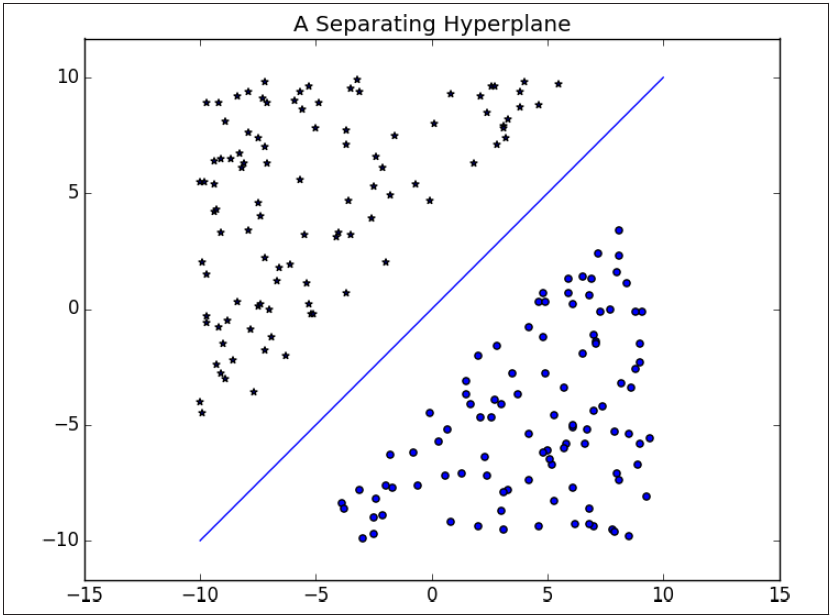

Encontrar um hiperplano como esse é um problema de otimização que envolve técnicas que são avançadas demais para nós. Um problema diferente é que um hiperplano de separação pode simplesmente não existir. Por exemplo, em nosso conjunto de dados "quem paga?" não há uma linha que separe perfeitamente os usuários que pagam dos que não pagam.

Podemos (às vezes) contornar isso, transformando os dados em um espaço de dimensão superior. Por exemplo, considere o conjunto de dados unidimensional simples:

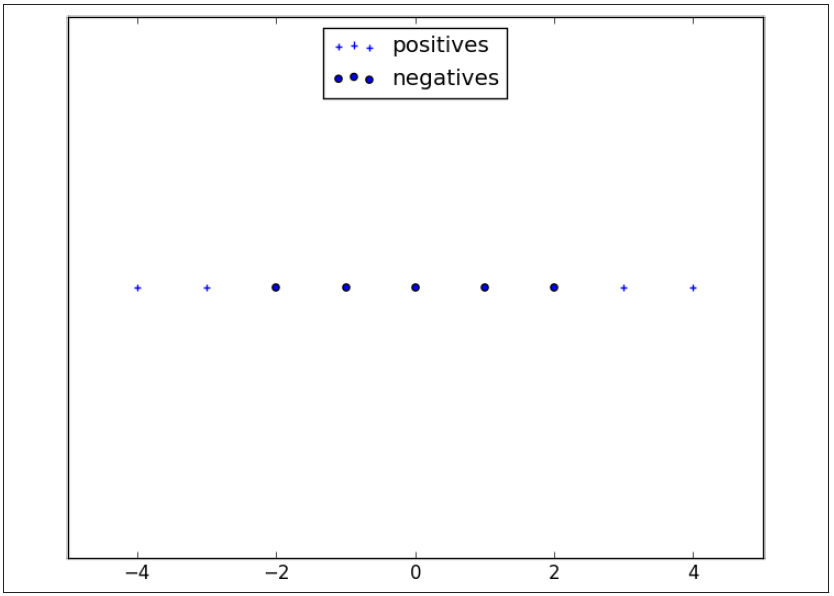

É claro que não há hiperplano que separe os exemplos positivos dos negativos. No entanto, observe o que acontece quando mapeamos esse conjunto de dados para duas dimensões enviando o ponto $x$ para $(x,x^2)$. De repente, é possível encontrar um hiperplano que divide os dados:

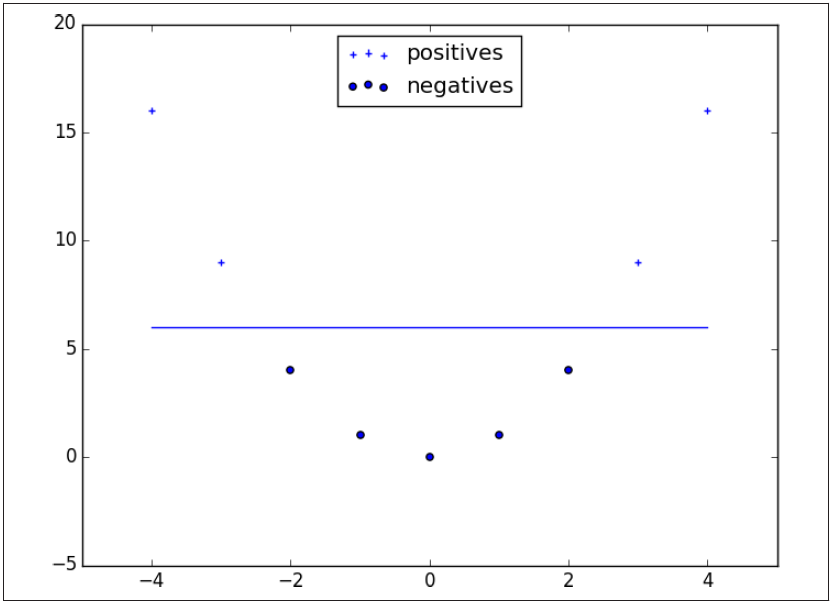

Isso geralmente é chamado de truque do *kernel*, porque, em vez de mapear os pontos no espaço de dimensão superior (que pode ser caro se houver muitos pontos e o mapeamento for complicado), podemos usar uma função "kernel" para calcular os produtos pontuais no espaço de dimensão superior e usá-los para encontrar um hiperplano.

É difícil (e provavelmente não é uma boa ideia) usar *support vector machines* sem depender de softwares de otimização especializados escritos por pessoas com o conhecimento especializado apropriado, por isso teremos que deixar nosso tratamento aqui.

## Para explorar

* O `scikit-learn` possui módulos tanto para [regressão logística](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) quanto para [*support vector machines*](http://scikit-learn.org/stable/modules/svm.html).

* [`libsvm`](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) é a implementação de *support vector machines* que o `scikit-learn` está usando nos bastidores. Seu site tem uma variedade de documentação útil sobre *support vector machines*.